In [31]:
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Loading the data

In [10]:
data_train = pd.read_csv("train.csv", sep=',', encoding='latin1')
data_test = pd.read_csv("test.csv", sep=',', encoding='latin1')
data_submission = pd.read_csv("sample_submission.csv", sep=',', encoding='latin1')

In [11]:
data_train = data_train.dropna()

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
textID           27480 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27480 non-null object
dtypes: object(4)
memory usage: 1.0+ MB


In [13]:
data_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [14]:
data_submission.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


# Exploratory Data Analysis

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import emoji
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import collections

In [16]:
sentiment_count=data_train.groupby('sentiment').count()
sentiment_count

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11117,11117,11117
positive,8582,8582,8582


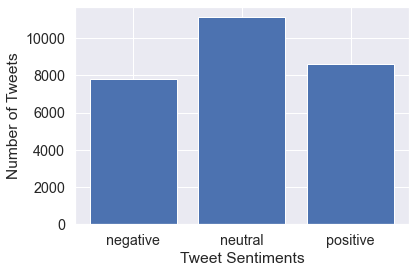

In [17]:
sentiment_count=data_train.groupby('sentiment').count()
plt.bar(sentiment_count.index.values, sentiment_count['textID'])
plt.xlabel('Tweet Sentiments')
plt.ylabel('Number of Tweets')
plt.show()

In [18]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [19]:
tc = TextCounts()
df_eda = tc.fit_transform(data_train.text)
# Add sentiment to df_eda
df_eda['sentiment'] = data_train.sentiment

In [20]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
             count       mean       std  min  25%   50%   75%   max
sentiment                                                          
negative    7781.0  13.993831  7.119993  0.0  8.0  13.0  20.0  36.0
neutral    11117.0  12.873707  7.317337  0.0  7.0  12.0  18.0  47.0
positive    8582.0  13.609532  6.951817  1.0  8.0  13.0  19.0  40.0


C:\Users\Rez\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


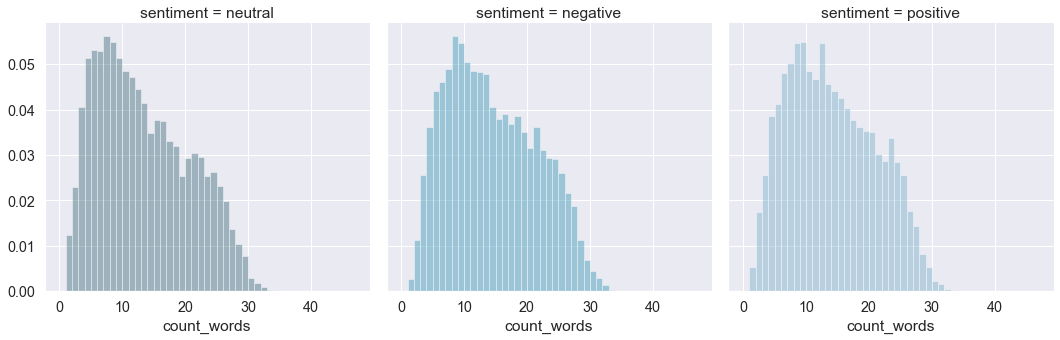

In [21]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_hashtags
------------------------------------
             count      mean       std  min  25%  50%  75%  max
sentiment                                                      
negative    7781.0  0.021977  0.164778  0.0  0.0  0.0  0.0  3.0
neutral    11117.0  0.022218  0.170069  0.0  0.0  0.0  0.0  4.0
positive    8582.0  0.021091  0.169035  0.0  0.0  0.0  0.0  5.0


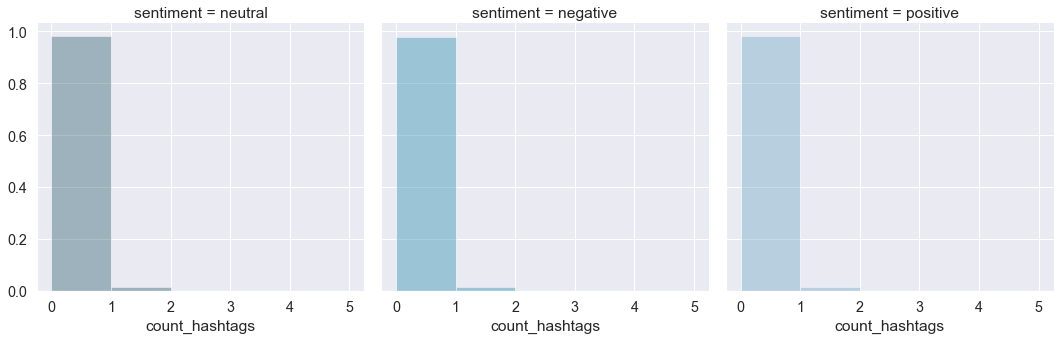

In [22]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
             count      mean       std  min  25%  50%  75%   max
sentiment                                                       
negative    7781.0  0.266418  1.054719  0.0  0.0  0.0  0.0  22.0
neutral    11117.0  0.244940  1.086657  0.0  0.0  0.0  0.0  26.0
positive    8582.0  0.277558  1.035488  0.0  0.0  0.0  0.0  24.0


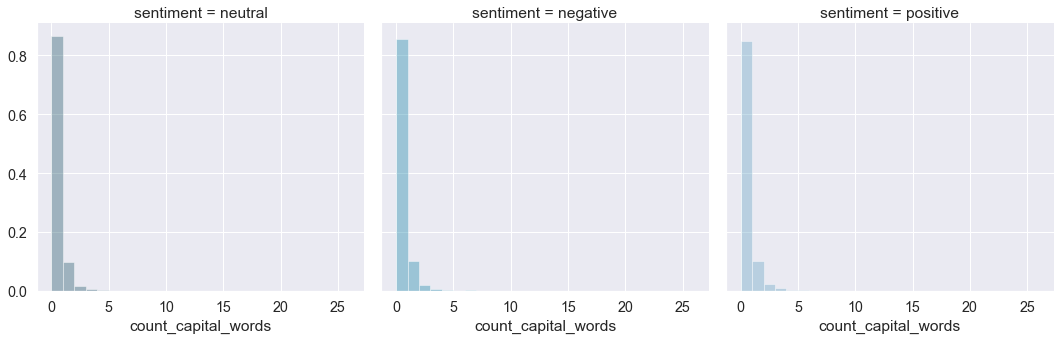

In [23]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
             count      mean       std  min  25%  50%  75%   max
sentiment                                                       
negative    7781.0  0.644390  1.609461  0.0  0.0  0.0  1.0  59.0
neutral    11117.0  0.636413  1.675780  0.0  0.0  0.0  1.0  98.0
positive    8582.0  0.870776  1.518472  0.0  0.0  0.0  1.0  42.0


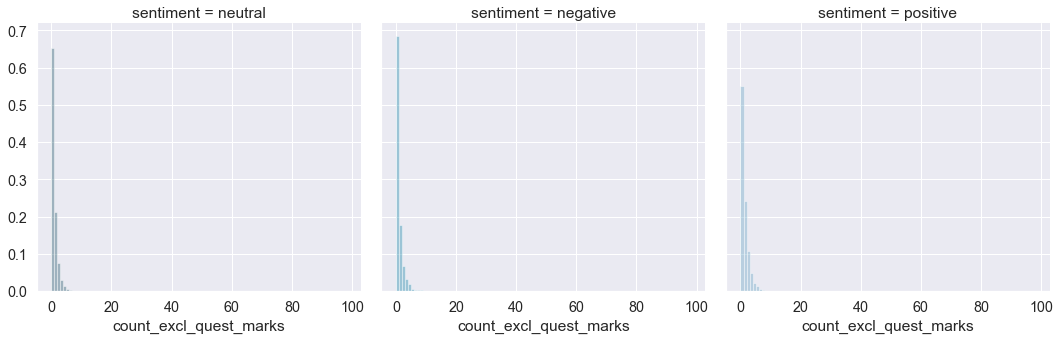

In [24]:
show_dist(df_eda, 'count_excl_quest_marks')

# Text Cleaning
Before we start using the tweets' text we clean it. We'll do the this in the class CleanText:
- remove the **mentions**
- remove the **hash tag sign** (#) but not the actual tag as this may contain information
- set all words to **lowercase**
- remove all **punctuations**, including the question and exclamation marks
- remove the **urls** as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes
- make sure the converted **emojis** are kept as one word. 
- remove **digits**
- remove **stopwords**
- apply the **PorterStemmer** to keep the stem of the words

In [71]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [28]:
ct = CleanText()
sr_clean = ct.fit_transform(data_train.text)
sr_clean.sample(5)

21525                                 shelbi twp
17888                    haha also look amaz fun
10991              puppi sick one put hand momma
20826                            worst kind news
16440    cool wish could av gone da live couldnt
Name: text, dtype: object

In [29]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

77 records have no words left after text cleaning


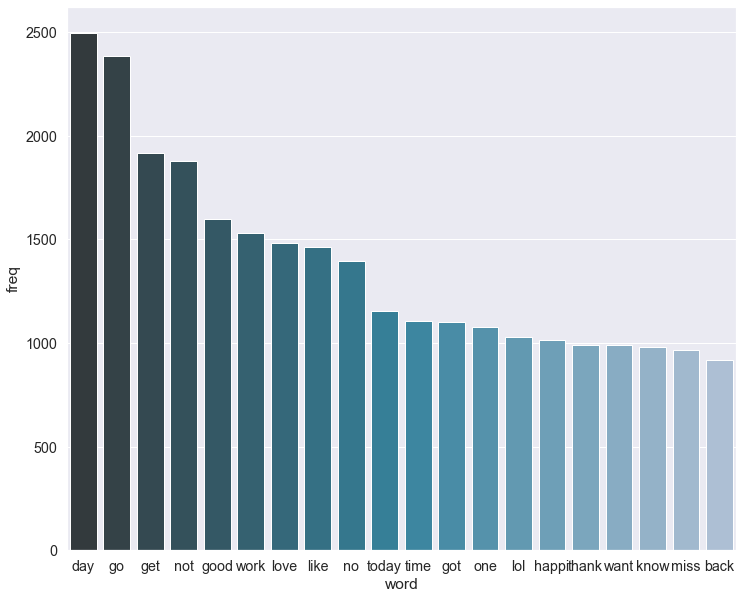

In [32]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

## wordcloud

In [78]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import re

In [64]:
df =  pd.read_csv("train.csv", sep=',', encoding='latin1')

In [65]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [72]:
# Positive
pos_df = df[df['sentiment']=='positive']

# Negative
neg_df = df[df['sentiment']=='negative']

# Neutral
neu_df = df[df['sentiment']=='neutral']

In [73]:
pos_df = pos_df.dropna()
neg_df = neg_df.dropna()
neu_df = neu_df.dropna()

In [74]:
ct = CleanText()
sr_clean_pos_df = ct.fit_transform(pos_df.text)
sr_clean_neg_df = ct.fit_transform(neg_df.text)
sr_clean_neu_df = ct.fit_transform(neu_df.text)

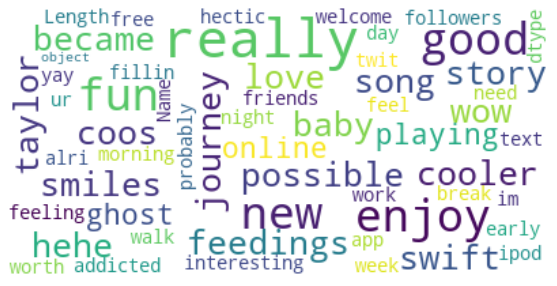

In [75]:
# Positive wordcloud
wordcloud = WordCloud(
                    background_color='white',
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(sr_clean_pos_df))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

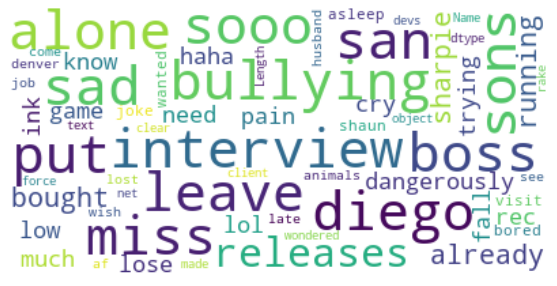

In [76]:
# Negative wordcloud
wordcloud = WordCloud(
                    background_color='white',
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(sr_clean_neg_df))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

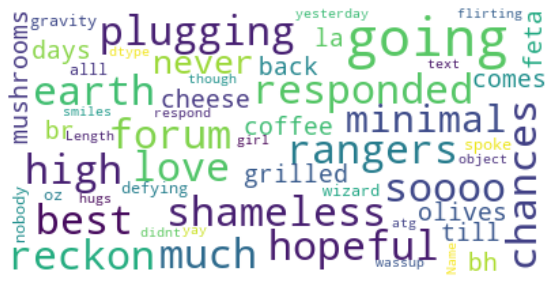

In [77]:
# Negative wordcloud
wordcloud = WordCloud(
                    background_color='white',
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(sr_clean_neu_df))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()